In [1]:
%config IPCompleter.use_jedi = False
from loader import load_data
import numpy as np
from sklearn.linear_model import RidgeCV
from rascal.representations import SphericalInvariants as SOAP
from rascal.utils import get_optimal_radial_basis_hypers
from rascal.neighbourlist.structure_manager import mask_center_atoms_by_id
from skcosmo.model_selection import atom_groups_by_frame
from sklearn.linear_model import LinearRegression, Ridge
from copy import deepcopy
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

Original error:
No module named 'sklearn.utils._tags'


In [2]:
train_structures, test_structures, train_properties, test_properties = load_data("./make_tensor_data/train_tensor/CSD-3k+S546_shift_tensors.xyz",\
                                                                                    "./make_tensor_data/test_tensor/CSD-500+104-7_shift_tensors.xyz",random_subsample_train=10,selected_species=1,random_subsample_test=200)

In [19]:
train_structures[0].arrays["center_atoms_mask"]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True])

In [10]:
class BufferedSOAPFeatures:
    def __init__(self, structures, calculator_params, calculator=SOAP, optimize=True, optimize_radial=20, n_cores=4):
        self.X = None
        self.structures = structures
        self.calculator = calculator
        self.calculator_params = calculator_params
        self.optimize = optimize
        self.optimize_radial = optimize_radial
        self.n_cores = n_cores

    def get_features(self, update_params):
        
        updated_params = self.calculator_params.copy()
        
        for key, value in update_params.items():
            
            if isinstance(value, np.integer):
                value = int(value)
            if isinstance(value, np.floating):
                value = float(value)
            if isinstance(value, np.ndarray):
                value = value.tolist()
                
            updated_params[key] = value

        
        if self.X is None:
            #find optimal params here
            if self.optimize is True:
                updated_params = get_optimal_radial_basis_hypers_parallel(updated_params,self.structures,expanded_max_radial=self.optimize_radial,num_cores=self.n_cores)
            self.X = get_features_in_parallel(self.structures,self.calculator,updated_params,n_cores=self.n_cores)
        
        else:
            
            if updated_params == self.calculator_params:
                pass
            else:
                #find optimal params here
                if self.optimize is True:
                    updated_params = get_optimal_radial_basis_hypers_parallel(updated_params,self.structures,expanded_max_radial=self.optimize_radial,num_cores=self.n_cores)
                self.X = get_features_in_parallel(self.structures,self.calculator,updated_params, n_cores=self.n_cores)
        
        self.calculator_params = updated_params
        
        return self.X

In [3]:
hypers = dict(soap_type="PowerSpectrum",
              interaction_cutoff=3.,
              max_radial=8,
              max_angular=8,
              gaussian_sigma_constant=0.3,
              gaussian_sigma_type="Constant",
              radial_basis="GTO",
              normalize=True,
              cutoff_smooth_width=0.3,
              optimization=
                    dict(
                            Spline=dict(
                               accuracy=1.0e-05
                            )
                        ),
              compute_gradients=False,
              
              )

In [13]:
SOAP_HYPERS = {
    "soap_type": "PowerSpectrum",
    "interaction_cutoff": 4.5,
    "max_radial": 9,
    "max_angular": 9,
    "gaussian_sigma_constant": 0.1,
    "gaussian_sigma_type": "Constant",
    "cutoff_smooth_width": 0.5,
    "radial_basis": "GTO",
    "expansion_by_species_method": "user defined",
    "global_species": [1, 6, 7, 8, 16],
    "compute_gradients": False,
    "normalize": True,
}

In [15]:

from loader import load_data
from rascal.representations import SphericalInvariants as SOAP

train_structures, test_structures, train_properties, test_properties = load_data("./make_tensor_data/train_tensor/CSD-3k+S546_shift_tensors.xyz",\
                                                                                    "./make_tensor_data/test_tensor/CSD-500+104-7_shift_tensors.xyz",selected_species=100,random_subsample_test=200)

calculator = SOAP(**SOAP_HYPERS)
print(calculator.transform(train_structures).get_features(calculator))

array([], shape=(0, 0), dtype=float64)

In [4]:
%pip install deepdiff

     |████████████████████████████████| 68 kB 793 kB/s eta 0:00:011
  Created wheel for ordered-set: filename=ordered_set-4.0.2-py2.py3-none-any.whl size=8209 sha256=2531f03727e0b9aac07c2ccb9d4c1c7d796c9f790732d4100131182cacd5bc28
  Stored in directory: /home/kellner/.cache/pip/wheels/a1/09/42/0b963b1d5423ddc87cb4ba9f475e09838d3813300b52a866ea
Successfully built ordered-set
You should consider upgrading via the '/ssd/scratch/kellner/miniconda3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [11]:
from copy import deepcopy

hypers = dict(soap_type="PowerSpectrum",
              interaction_cutoff=3.,
              max_radial=4,
              max_angular=4,
              gaussian_sigma_constant=0.3,
              gaussian_sigma_type="Constant",
              radial_basis="GTO",
              normalize=True,
              cutoff_smooth_width=0.3,
              cutoff_function_type="RadialScaling",
              optimization=
                    dict(
                            Spline=dict(
                               accuracy=1.0e-05
                            )
                        ),
              cutoff_function_parameters= dict(rate=1,
                    scale=3.0,
                    exponent=6
                        ),
              compute_gradients=False,
              expansion_by_species_method="user defined",
              global_species=[1, 6, 7, 8, 16]
              )

nested_param = dict(rate=1,
                    scale=3.0,
                    exponent=6
                        )

"""space = [Real(10**-5, 10**2, "log-uniform", name='alpha'),
        Real(0.05,1.5, "uniform", name="gaussian_sigma_constant"),
        Real(2.,4.5, "uniform", name="interaction_cutoff")]"""

space = [Real(10**-5, 10**2, "log-uniform", name='alpha'),
        Real(2.5,3.5, "uniform", name="scale"),
        ]

reg = Ridge()
y = train_properties
atom_groups = atom_groups_by_frame(train_structures)
Feature_gen = BufferedSOAPFeatures(train_structures, hypers,n_cores=8)


@use_named_args(space)
def soap_objective(**params):
    update_dict = {}
    
    new_params = params.copy()
    nested_dict_param = deepcopy(Feature_gen.calculator_params)
    nested_dict_param = nested_dict_param["cutoff_function_parameters"]
    
    for key, value in new_params.items():
        if key in Feature_gen.calculator_params:
            #hypers[key] = value
            update_dict[key] = params.pop(key, None)
        if key in nested_param:
            nested_dict_param[key] = params.pop(key, None)
            #print("I update my {} to {}".format(key,value))
        
        update_dict["cutoff_function_parameters"] = nested_dict_param
            
            
    #print(update_dict)
    reg.set_params(**params)
    
    print("step")
    
    X = Feature_gen.get_features(update_dict)
    #print(X.shape)
    
    #print(Feature_gen.hypers["max_angular"])
    splits = list(GroupKFold(n_splits=5).split(X,y,groups=atom_groups))
    
    return -np.mean(cross_val_score(reg, X, y, cv=splits, n_jobs=-1,
                                    scoring="neg_mean_squared_error"))

#res_gp = gp_minimize(soap_objective, space, n_calls=10, random_state=0)

In [12]:
res_gp = gp_minimize(soap_objective, space, n_calls=50, random_state=0)

step
step
step
step
step
step
step
step
step
step
step
step
step
step
step
step
step
step
step
step
step
step
step
step
step
step
step
step
step
step
step
step
step
step
step
step
step
step
step
step
step
step
step
step
step
step
step
step
step
step


<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

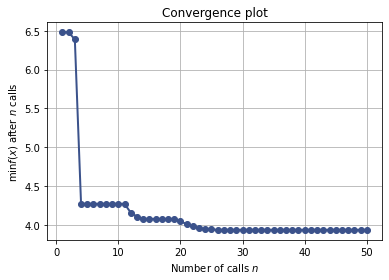

In [13]:
from skopt.plots import plot_convergence

plot_convergence(res_gp)

In [44]:
%pip install 'scipy==1.5.2'

     |████████████████████████████████| 25.7 MB 5.7 MB/s eta 0:00:01    |█▎                              | 1.1 MB 5.7 MB/s eta 0:00:05
  Attempting uninstall: scipy
    Found existing installation: scipy 1.8.0
    Uninstalling scipy-1.8.0:
      Successfully uninstalled scipy-1.8.0
You should consider upgrading via the '/ssd/scratch/kellner/miniconda3/bin/python3.8 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [36]:
res_gp.values()

dict_values([[0.015483372217403117, 2.5], 3.313575525603137, array([3.65536083, 6.32636629, 3.6975228 , 3.46802817, 3.45641314,
       5.06179093, 3.51125163, 3.46876761, 3.5136904 , 3.48989071,
       3.50493586, 3.50099413, 3.50112866, 3.50094604, 3.5559285 ,
       3.32775115, 3.33924902, 3.31975527, 3.57056635, 3.37097561,
       3.31716189, 3.45578305, 3.49655702, 3.31808906, 3.31601712,
       3.32087739, 3.31859438, 3.31480082, 3.31684523, 3.31904798,
       3.3202476 , 3.31841093, 3.84031924, 3.3503173 , 3.31768459,
       3.31527084, 3.31608976, 3.31632942, 3.31670359, 3.31526954,
       3.31560703, 3.31607446, 3.31602657, 3.31628384, 3.31634726,
       3.31357553, 3.31494412, 3.31552273, 3.32083717, 3.31540301]), [[0.14122524199027556, 3.3442657485810177], [10.130230408794516, 3.3472517387841254], [0.23171058704005043, 2.8843817072927], [0.0012098798555754894, 2.556712977317443], [0.0008102034013106679, 2.97766511732135], [4.843743102654484, 2.979977172375057], [0.00561685965

In [39]:
%pip install sklearn --upgrade

  Using cached sklearn-0.0-py2.py3-none-any.whl
You should consider upgrading via the '/ssd/scratch/kellner/miniconda3/bin/python3.8 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [40]:
reg.alpha

2.043192897589359

In [42]:
import scipy

In [43]:
scipy.__version__

'1.8.0'

In [42]:
paramdict = {}
for param in zip(space,res_gp.x):
    paramdict[param[0].name] = param[1]

In [43]:
paramdict

{'alpha': 0.0033970924303804028,
 'gaussian_sigma_constant': 0.05557628804633241,
 'interaction_cutoff': 3.6601119046746073}

In [28]:
import cProfile

In [30]:
cProfile.run("gp_minimize(soap_objective, space, n_calls=10, random_state=0)")

         551440 function calls (545703 primitive calls) in 168.840 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     2935    0.003    0.000    0.030    0.000 <__array_function__ internals>:2(all)
      117    0.000    0.000    0.009    0.000 <__array_function__ internals>:2(allclose)
      141    0.000    0.000    0.001    0.000 <__array_function__ internals>:2(alltrue)
        1    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(amax)
       19    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(amin)
      422    0.000    0.000    0.005    0.000 <__array_function__ internals>:2(any)
      145    0.000    0.000    0.002    0.000 <__array_function__ internals>:2(append)
        1    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(argmax)
     2014    0.001    0.000    0.004    0.000 <__array_function__ internals>:2(argmin)
       13    0.000    0.000    0.002    0.000 

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
from skopt.plots import plot_convergence


plot_convergence(res_gp)
plt.xlim(3,50)
plt.ylim(0.8,1.)

In [ ]:
reg.

In [41]:
res_gp.x

[0.0033970924303804028, 0.05557628804633241, 3.6601119046746073]

In [26]:
np.sqrt(0.8)

0.8944271909999159

In [6]:

def split(a, n):
    k, m = divmod(len(a), n)
    return (a[i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(n))


In [54]:
list(split(range(10),3))

[range(0, 4), range(4, 7), range(7, 10)]

In [48]:
help(divmod)

Help on built-in function divmod in module builtins:

divmod(x, y, /)
    Return the tuple (x//y, x%y).  Invariant: div*y + mod == x.



In [4]:
from helpers import grouper

In [5]:

from joblib import Parallel, delayed

In [9]:
import joblib
from itertools import combinations_with_replacement
from joblib import Parallel, delayed, parallel_backend
from helpers import grouper
from joblib.externals.loky import set_loky_pickler

def split(a, n):
    #splits a list into n chunks, fails if len(a) is 0
    k, m = divmod(len(a), n)
    return (a[i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(n))

def get_features(frames,calculator,hypers):
    calculatorinstance = calculator(**hypers)
    #print("worker spawned")
    return calculatorinstance.transform(frames).get_features(calculatorinstance)

def get_features_by_species(frames,calculator,hypers):
    calculatorinstance = calculator(**hypers)
    #print("worker spawned")
    return calculatorinstance.transform(frames).get_features_by_species(calculatorinstance)


def get_features_in_parallel(frames,calculator,hypers,blocksize=25,n_cores=-1):
    """helper function that returns the features of a calculator (from calculator.transform())
       in parallel
    """
    
    #block is necessary to ensure that shape of the chunks is equal
    #replace by get_atomic_species functions
    

    with parallel_backend(backend="threading"):
        results = Parallel(n_jobs=n_cores)(delayed(get_features)(frame, calculator, hypers) for frame in grouper(blocksize,frames))
    
    return np.concatenate(results)

def get_features_in_parallel_by_species(frames,calculator,hypers,blocksize=25,n_cores=-1):
    """helper function that returns the features of a calculator (from calculator.transform())
       in parallel
    """
    
    #block is necessary to ensure that shape of the chunks is equal
    #replace by get_atomic_species functions
    

    with parallel_backend(backend="threading"):
        intermediate_results = Parallel(n_jobs=n_cores)(delayed(get_features_by_species)(frame, calculator, hypers) for frame in grouper(blocksize,frames))
    
    results = {}
    
    #print(intermediate_results)
    for key in intermediate_results[0].keys():
        results[key] = np.concatenate([chunk[key] for chunk in intermediate_results])
    
    return results


In [8]:
from rascal.representations import SphericalExpansion

In [7]:
get_features_by_species(train_structures[:25],SphericalExpansion,HYPERS)

NameError: name 'HYPERS' is not defined

In [18]:
train_structures[:25]

[Atoms(symbols='N4O4C20H20', pbc=True, cell=[13.564047596, 5.79502231063, 5.60401339238], center_atoms_mask=..., cs_iso=..., cs_tensor=...),
 Atoms(symbols='C18H36N8O8', pbc=True, cell=[[7.131018008, 0.0, 0.0], [-3.35710500272, 9.26783468512, 0.0], [-2.0474364974, -1.27908356908, 9.61766816655]], center_atoms_mask=..., cs_iso=..., cs_tensor=...),
 Atoms(symbols='C28H16N32O32', pbc=True, cell=[[12.722757232, 0.0, 0.0], [0.0, 11.8045558426, 0.0], [-0.879600543992, 0.0, 8.09690265277]], center_atoms_mask=..., cs_iso=..., cs_tensor=...),
 Atoms(symbols='C64H118N14O4', pbc=True, cell=[[6.71344207, 0.0, 0.0], [-0.499359248051, 7.71360395615, 0.0], [-1.05722614374, -2.25817365532, 31.890877292]], center_atoms_mask=..., cs_iso=..., cs_tensor=...),
 Atoms(symbols='C32H32N16O16', pbc=True, cell=[[13.24907966, 0.0, 0.0], [0.0, 11.1910736183, 0.0], [-0.519960131257, 0.0, 6.25747407802]], center_atoms_mask=..., cs_iso=..., cs_tensor=...),
 Atoms(symbols='C40H28O18', pbc=True, cell=[[12.009052166, 0

In [6]:
calculatorinstance = SOAP(**hypers)
feats = calculatorinstance.transform(train_structures[:25]).get_features(calculatorinstance)

In [7]:
feats

array([], shape=(0, 0), dtype=float64)

In [11]:
HYPERS = {
    "interaction_cutoff": 4.5,
    "max_radial": 18,
    "max_angular": 9,
    "gaussian_sigma_constant": 0.1,
    "gaussian_sigma_type": "Constant",
    "cutoff_smooth_width": 0.5,
    "radial_basis": "GTO",
    "compute_gradients": False,
    "expansion_by_species_method": "user defined",
    "global_species": [1, 6, 7, 8, 16],
}

In [8]:
start_time = time.time()
feat = get_features_in_parallel_by_species(train_structures,SphericalExpansion,HYPERS)
print("--- %s seconds ---" % (time.time() - start_time))

NameError: name 'time' is not defined

In [ ]:
train_structures

[Atoms(symbols='N4O4C20H20', pbc=True, cell=[13.564047596, 5.79502231063, 5.60401339238], center_atoms_mask=..., cs_iso=..., cs_tensor=...),
 Atoms(symbols='C18H36N8O8', pbc=True, cell=[[7.131018008, 0.0, 0.0], [-3.35710500272, 9.26783468512, 0.0], [-2.0474364974, -1.27908356908, 9.61766816655]], center_atoms_mask=..., cs_iso=..., cs_tensor=...),
 Atoms(symbols='C28H16N32O32', pbc=True, cell=[[12.722757232, 0.0, 0.0], [0.0, 11.8045558426, 0.0], [-0.879600543992, 0.0, 8.09690265277]], center_atoms_mask=..., cs_iso=..., cs_tensor=...),
 Atoms(symbols='C64H118N14O4', pbc=True, cell=[[6.71344207, 0.0, 0.0], [-0.499359248051, 7.71360395615, 0.0], [-1.05722614374, -2.25817365532, 31.890877292]], center_atoms_mask=..., cs_iso=..., cs_tensor=...),
 Atoms(symbols='C32H32N16O16', pbc=True, cell=[[13.24907966, 0.0, 0.0], [0.0, 11.1910736183, 0.0], [-0.519960131257, 0.0, 6.25747407802]], center_atoms_mask=..., cs_iso=..., cs_tensor=...),
 Atoms(symbols='C40H28O18', pbc=True, cell=[[12.009052166, 0

In [36]:
feat

{}

In [ ]:
mysoap = SphericalExpansion(**HYPERS)
my_feat = mysoap.transform(train_structures).get_features_by_species(mysoap)

In [ ]:
mydict = {"a","b"}

In [22]:
feat_gen = SOAP(**SOAP_HYPERS)

In [23]:
my_feat = feat_gen.transform(train_structures[0]).get_features_by_species(feat_gen)

In [24]:
my_feat.keys()

dict_keys([])

In [5]:
def _get_features_in_parallel(frames,calculator,blocksize=100,n_jobs=-1):
    """helper function that returns the features of a calculator (from calculator.transform())
       in parallel
    """
    #for np.concatenate. arrays in list should all have same shape
    hypers = calculator.hypers
    hypers["expansion_by_species_method"] = "user defined"
    hypers["global_species"] = get_all_species(frames).tolist()
    calculator.update_hyperparameters(**hypers)
    return np.concatenate(Parallel(n_jobs=2)(delayed(retrieve_features)(calculator, chunk)\
                                              for chunk in grouper(blocksize,frames)))


In [ ]:
grouper(25,frames)

In [19]:
joblib.cpu_count()

8

In [8]:
import time

In [ ]:
grouper(50,frames)

In [37]:
Parallel(n_jobs=2,verbose=1)(delayed(np.sqrt)(i ** 2) for i in range(10))

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.5s finished


[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]

In [36]:
from rascal.utils import get_optimal_radial_basis_hypers

In [55]:
SOAP_HYPERS = {
    "soap_type": "PowerSpectrum",
    "interaction_cutoff": 4.5,
    "max_radial": 9,
    "max_angular": 9,
    "gaussian_sigma_constant": 0.1,
    "gaussian_sigma_type": "Constant",
    "cutoff_smooth_width": 0.5,
    "radial_basis": "GTO",
    "expansion_by_species_method": "user defined",
    "global_species": [1, 6, 7, 8],
    "compute_gradients": False,
    "normalize": False,
}

SOAP_HYPERS = get_optimal_radial_basis_hypers(SOAP_HYPERS, train_structures, expanded_max_radial=30)

In [58]:
SOAP_HYPERS = {
    "soap_type": "PowerSpectrum",
    "interaction_cutoff": 4.5,
    "max_radial": 9,
    "max_angular": 0,
    "gaussian_sigma_constant": 0.1,
    "gaussian_sigma_type": "Constant",
    "cutoff_smooth_width": 0.5,
    "radial_basis": "GTO",
    "expansion_by_species_method": "user defined",
    "global_species": [1, 6, 7, 8],
    "compute_gradients": False,
    "normalize": False,
}

start_time = time.time()
SOAP_HYPERS = get_optimal_radial_basis_hypers(SOAP_HYPERS, train_structures, expanded_max_radial=30)
print("--- %s seconds ---" % (time.time() - start_time))

--- 5.575486183166504 seconds ---


In [47]:
sys.getsizeof(SOAP_HYPERS["optimization"])

232

In [53]:
sys.getsizeof(SOAP_HYPERS["optimization"]["RadialDimReduction"]["projection_matrices"])

232

In [45]:
import sys

In [46]:
sys.getsizeof(SOAP_HYPERS)

640

In [35]:




start_time = time.time()
get_features_in_parallel(train_structures,calculator=SOAP,hypers=SOAP_HYPERS)
print("--- %s seconds ---" % (time.time() - start_time))

--- 5.222474098205566 seconds ---


In [29]:
mysoap = SOAP(**SOAP_HYPERS)
soap_feats =  mysoap.transform(train_structures).get_features(mysoap)

In [30]:
np.allclose(feats,soap_feats)

True

In [35]:
split([1,2,3,4,5],5)

<generator object split.<locals>.<genexpr> at 0x7f9ac85bdcf0>

In [56]:
feats.shape

(134692, 12150)

In [36]:
type(grouper(10,np.arange(100)))

generator

In [38]:
type(split(np.arange(100),10))

generator

In [57]:
len(train_properties)

134692

In [28]:
import time

In [14]:
start_time = time.time()
_ = get_features_in_parallel(train_structures,calculator=SOAP,hypers=hypers,blocks=2)
print("--- %s seconds ---" % (time.time() - start_time))

NameError: name 'hypers' is not defined

In [6]:
import os
import copy
import numpy as np
import multiprocessing
from multiprocessing import shared_memory
from itertools import combinations_with_replacement
import ase
from rascal.representations import SphericalInvariants, SphericalExpansion

SOAP_HYPERS = {
    "soap_type": "PowerSpectrum",
    "interaction_cutoff": 4.5,
    "max_radial": 9,
    "max_angular": 9,
    "gaussian_sigma_constant": 0.1,
    "gaussian_sigma_type": "Constant",
    "cutoff_smooth_width": 0.5,
    "radial_basis": "GTO",
    "expansion_by_species_method": "user defined",
    "global_species": [1, 6, 7, 8, 16],
    "compute_gradients": False,
    "normalize": True,
}
CALCULATOR = None


def _compute_single(data):
    representation = CALCULATOR.transform(data["frame"])
    return representation.get_features(CALCULATOR)

def _compute_single_by_species(data):
    representation = CALCULATOR.transform(data["frame"])
    return representation.get_features_by_species(CALCULATOR)

def _initializer_spherical(hypers):
    global CALCULATOR
    CALCULATOR = SphericalExpansion(**hypers)
    
def _initializer(hypers):
    global CALCULATOR
    CALCULATOR = SphericalInvariants(**hypers)


def compute_soap(frames, passed_hyper, selected_features=None):
    hypers = copy.deepcopy(passed_hyper)

    if selected_features is not None:
        hypers["coefficient_subselection"] = selected_features

    calculator = SphericalInvariants(**hypers)

    if selected_features is not None:
        n_features = calculator.get_num_coefficients()
    else:
        # get_num_coefficients does not handle global_species, the factor of 10
        # comes from all the species pairs
        n_pairs = len(list(combinations_with_replacement(hypers["global_species"],2)))
        n_features = n_pairs * calculator.get_num_coefficients()

    #shape = (len(frames), n_features)

    with multiprocessing.Pool(
        processes=multiprocessing.cpu_count(),
        initializer=_initializer,
        initargs=(hypers,),
    ) as pool:

        iterator = pool.imap(
            _compute_single,
            map(
                lambda data: {"i": data[0], "frame": data[1]},
                enumerate(frames),
            ),
        )
        
        try:
            lengths = [len(frame.arrays["center_atoms_mask"].nonzero()[0]) for frame in frames]
        except:
            lengths = [len(frame) for frame in frames]
            
        cumulated_sum = np.cumsum([0, *lengths]) 
        result = np.zeros((np.sum(lengths),n_features),dtype=np.float64)
        
        for i,value in enumerate(iterator):
            result[cumulated_sum[i]:cumulated_sum[i+1]] = value

    return result

def compute_spex_by_species(frames, passed_hyper, selected_features=None):
    hypers = copy.deepcopy(passed_hyper)

    if selected_features is not None:
        hypers["coefficient_subselection"] = selected_features

    calculator = SphericalExpansion(**hypers)

    if selected_features is not None:
        n_features = calculator.get_num_coefficients()
    else:
        # get_num_coefficients does not handle global_species, the factor of 10
        # comes from all the species pairs
        n_pairs = len(list(combinations_with_replacement(hypers["global_species"],2)))
        n_features = n_pairs * calculator.get_num_coefficients()

    #shape = (len(frames), n_features)

    with multiprocessing.Pool(
        processes=multiprocessing.cpu_count(),
        initializer=_initializer_spherical,
        initargs=(hypers,),
    ) as pool:

        iterator = pool.imap(
            _compute_single_by_species,
            map(
                lambda data: {"i": data[0], "frame": data[1]},
                enumerate(frames),
            ),
        )
        
        """try:
            lengths = [len(frame.arrays["center_atoms_mask"].nonzero()[0]) for frame in frames]
        except:
            lengths = [len(frame) for frame in frames]
            
        cumulated_sum = np.cumsum([0, *lengths]) 
        result = np.zeros((np.sum(lengths),n_features),dtype=np.float64)
        
        """
        intermediate_results = []
        
        results = {}
        
        for i,value in enumerate(iterator):
            intermediate_results.append(value)
        
        for key in intermediate_results[0].keys():
            results[key] = np.concatenate([chunk[key] for chunk in intermediate_results])
        
        
        
    return results

In [20]:
8/2

4.0

In [ ]:
lengths = [len(frame.arrays["center_atoms_mask"].nonzero()[0]) for frame in frames]
cumulated_sum = np.cumsum([0, *lengths]) 

In [101]:
np.sum([len(frame.arrays["center_atoms_mask"].nonzero()[0]) for frame in train_structures])

134692

In [ ]:
len(list(combinations_with_replacement(SOAP_HYPERS["global_species"],2)))

In [6]:
import time

In [61]:
#multiprocessing.set_start_method("forkserver")
time = time.time()
features = compute_soap(train_structures)

CPU times: user 4 µs, sys: 3 µs, total: 7 µs
Wall time: 11.9 µs


In [24]:
start_time = time.time()
compute_soap(train_structures,SOAP_HYPERS)
print("--- %s seconds ---" % (time.time() - start_time))

--- 26.577285051345825 seconds ---


In [7]:
start_time = time.time()
mysoap = SOAP(**SOAP_HYPERS)
mysoap.transform(train_structures).get_features(mysoap)
print("--- %s seconds ---" % (time.time() - start_time))

--- 40.99152374267578 seconds ---


In [11]:
multiprocessing.cpu_count()

8

In [86]:
features.shape

(3662, 12150)

In [39]:
SOAP_HYPERS["global_species"]

[1, 6, 7]

In [5]:
from scipy.special import legendre, gamma
from copy import deepcopy
import numpy as np
import time
from rascal.representations.spherical_expansion import SphericalExpansion
from rascal.utils import get_radial_basis_covariance, get_radial_basis_pca, get_radial_basis_projections

def get_optimal_radial_basis_hypers_parallel(hypers, frames, blocksize=25,expanded_max_radial=-1,num_cores=4):
    """
    Helper function to compute an optimal radial basis following
    Goscinski et al, arxiv:2105.08717.
    hypers: dictionary
        hyperparameters for the desired representation. "max_radial" indicates
        the desired size of the optimal basis
    frames: ase.Atoms
        a list of structures used to estimate the optimal radial basis. can also
        be given as a list of frames blocks, in which case it computes the covariance
        incrementally (useful for large expanded_max_radial and/or large framesets)
    expanded_max_radial: int
        number of intermediate basis to be used to estimate the optimal basis.
        defaults to -1, in which case it is taken to be 2*max_radial
    Returns:
    -------
    optimal_hypers: dictionary
        hyperparameters including the optimal basis projectors
    """

    spherical_expansion_hypers = deepcopy(hypers)

    # removes parameters that don't make sense for a spherical expansion
    spherical_expansion_hypers.pop("normalize", None)
    spherical_expansion_hypers.pop("soap_type", None)
    spherical_expansion_hypers.pop("compute_gradients", None)
    spherical_expansion_hypers.pop("inversion_symmetry", None)

    if "optimization" in spherical_expansion_hypers:
        spherical_expansion_hypers["optimization"].pop("RadialDimReduction", None)

    if expanded_max_radial == -1:
        expanded_max_radial = 2 * hypers["max_radial"]
    spherical_expansion_hypers["max_radial"] = expanded_max_radial

    spex = SphericalExpansion(**spherical_expansion_hypers)

    # computes density expansion coefficients and covariance (incrementally if needed)
    if not type(frames[0]) is list:
        frames = [frames]
    
    feats = get_features_in_parallel_by_species(frames[0],SphericalExpansion,spherical_expansion_hypers,blocksize=blocksize)
    
    #get_features_in_parallel_by_species(frames[0], calculator=SphericalExpansion, \hypers=spherical_expansion_hypers)
    #compute_spex(frames[0],spherical_expansion_hypers)
    """get_features_in_parallel(frames[0], calculator=SphericalExpansion, \
                         hypers=spherical_expansion_hypers)"""
    
    
    
    cov = get_radial_basis_covariance(spex, feats)
    nframes = len(frames[0])
    
    for fr in frames[1:]:
        feats = spex.transform(fr).get_features_by_species(spex)
        icov = get_radial_basis_covariance(spex, feats)
        # bit perverse: both cov and icov are normalized, so we need to
        # un-normalize before accumulating
        for s in cov.keys():
            cov[s] = (cov[s] * nframes + icov[s] * len(fr)) / (nframes + len(fr))
        nframes += len(fr)

    # principal components from the covariance
    p_val, p_vec = get_radial_basis_pca(cov)

    # converts to the format suitable for hypers
    p_mat = get_radial_basis_projections(p_vec, hypers["max_radial"])

    # assemble the updated hypers
    optimal_hypers = deepcopy(hypers)
    if not "optimization" in optimal_hypers:
        optimal_hypers["optimization"] = {}
    optimal_hypers["optimization"] = {
        "RadialDimReduction": {"projection_matrices": p_mat},
    }

    if not "Spline" in optimal_hypers["optimization"]:
        optimal_hypers["optimization"]["Spline"] = {"accuracy": 1e-8}

    return optimal_hypers

In [4]:
SOAP_HYPERS = {
    "soap_type": "PowerSpectrum",
    "interaction_cutoff": 4.5,
    "max_radial": 9,
    "max_angular": 9,
    "gaussian_sigma_constant": 0.1,
    "gaussian_sigma_type": "Constant",
    "cutoff_smooth_width": 0.5,
    "radial_basis": "GTO",
    "expansion_by_species_method": "user defined",
    "global_species": [1, 6, 7, 8, 16],
    "compute_gradients": False,
    "normalize": False,
}

start_time = time.time()
SOAP_HYPERS = get_optimal_radial_basis_hypers_parallel(SOAP_HYPERS, train_structures, expanded_max_radial=20, blocksize=25)
print("--- %s seconds ---" % (time.time() - start_time))

NameError: name 'time' is not defined

In [95]:
start_time = time.time()
SOAP_HYPERS = get_optimal_radial_basis_hypers(SOAP_HYPERS, train_structures, expanded_max_radial=20)
print("--- %s seconds ---" % (time.time() - start_time))

--- 44.46110129356384 seconds ---


In [112]:
for key in feat.keys():
    print(np.equal(feat[key],my_feat[key]))

[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]
[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]
[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]
[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  

In [75]:
feat[(1,)][-1000]

array([ 1.61096077e-03,  4.12982012e-06,  7.78346713e-06,  5.31525923e-07,
        3.06907294e-06, -1.36602380e-06, -2.98652990e-06, -3.26303524e-06,
        2.73217042e-06, -5.50975307e-06, -7.05171349e-07,  3.53880289e-06,
        6.74865133e-06,  3.14175617e-07, -5.61144676e-07, -8.72513218e-07,
       -3.11290796e-06, -3.38386856e-06, -9.92018532e-07, -1.19032075e-05,
       -1.09938769e-05,  5.69084903e-06, -2.34788979e-06,  1.77574607e-06,
       -6.13369959e-06, -3.13528632e-06,  2.26332881e-06, -3.59902746e-06,
       -1.22400555e-05,  7.86851329e-06,  4.97600284e-06, -3.07423202e-07,
       -5.06172739e-06, -2.05555550e-06,  1.08991136e-06, -3.38540014e-06,
        4.83562422e-06, -1.99152681e-06,  4.13255998e-06, -2.07195307e-06,
        1.82864928e-06, -6.32409268e-06, -3.34862790e-06,  6.17707270e-06,
        3.93006261e-06,  3.22510080e-06, -5.80384756e-07,  2.06395208e-06,
        1.51530368e-06,  2.94945636e-06,  9.21527590e-07, -3.60663088e-06,
        8.41772686e-06,  

In [68]:
len(train_structures)

200

In [60]:
my_feat.keys()

dict_keys([(1,), (6,), (7,), (8,), (16,)])

In [62]:
len(myfeat[(8,)])

8010

In [61]:
myfeat.keys()

dict_keys([(1,), (6,), (7,), (8,), (16,)])

In [53]:
mysoap = SphericalExpansion(**HYPERS)
my_feat = mysoap.transform(train_structures).get_features_by_species(mysoap)

In [54]:
len(my_feat[(8,)])

8010

In [56]:
len(train_properties)

8010